In [1]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import statsmodels.api as sm

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

# HELPER FUNCTIONS

In [2]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names


def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()

In [3]:
vars_to_plot = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r_G', 'w', 'Ex', 'Im', 'CA']

# DATA PREPARATION

In [4]:
wb_indicator = ["NY.GDP.MKTP.KD", #GDP(constant 2015 - yearly)
                 "NE.CON.TOTL.CD", #Consumption(current - yearly)
                 "NE.GDI.FTOT.CD", #Investment(current - yearly)
                 "BN.CAB.XOKA.CD", #Current account(BoP,current - yearly)
                 "BX.GSR.GNFS.CD", #Exports(BoP,current - yearly)
                 "BM.GSR.GNFS.CD", #Imports(BoP,current - yearly)
                ]

fred_indicator = ["RKNANPUAA666NRUG", #Stock of Capital (constant 2017 - yearly)
                 ]
rename_dict = {'NY.GDP.MKTP.KD':'Y',
               'NE.GDI.FTOT.CD':'I',
               'NE.CON.TOTL.CD':'C',
               'BN.CAB.XOKA.CD':'CA', #Current account(BoP,current) 
               'BX.GSR.GNFS.CD':'Ex', #Exports(BoP,current) 
               'BM.GSR.GNFS.CD':'Im', #Imports(BoP,current) 
               'RKNANPUAA666NRUG':'K', #Stock of Capital constant 2017
              }

In [5]:
from pandas_datareader import fred, wb
import pandas as pd 
import os

fred_df = fred.FredReader(fred_indicator, start='1900-01-01', end=None).read()
wb_df = wb.download(indicator=wb_indicator, start='1900-01-01', end=None, country='UA')

wb_df = wb_df.droplevel(level=0)
wb_df.index = pd.to_datetime(wb_df.index)

data = fred_df.join(wb_df).rename(columns=rename_dict)
#data.to_csv('GENERAL.csv')

#data = pd.read_csv('Ukraine_RBC.csv', index_col=0, parse_dates=['DATE'])

The following data is yearly so in the further procedures we disaggregate it to quarterly frequency.

In [6]:
from tsdisagg import disaggregate_series

In [7]:
annual_Y = data['Y'].copy().dropna()
annual_Y.index.inferred_freq
quarterly_Y = disaggregate_series(annual_Y, target_freq='QS')
data = data.drop(columns=['Y']).join(quarterly_Y,how='outer')
data.head()

,K,C,I,CA,Ex,Im,Y
1990-01-01,8298419.5,5.857143e+10,NaN,NaN,NaN,NaN,4.105102e+10
1990-04-01,NaN,NaN,NaN,NaN,NaN,NaN,4.077941e+10
1990-07-01,NaN,NaN,NaN,NaN,NaN,NaN,4.023618e+10
1990-10-01,NaN,NaN,NaN,NaN,NaN,NaN,3.942135e+10
1991-01-01,8479779.0,5.487179e+10,1.538462e+10,NaN,NaN,NaN,3.833491e+10


In [8]:
annual_K = data['K'].copy().dropna()
annual_K.index.inferred_freq
quarterly_K = disaggregate_series(annual_K, target_freq='QS')
data = data.drop(columns=['K']).join(quarterly_K,how='outer')
data.head()

,C,I,CA,Ex,Im,Y,K
1990-01-01,5.857143e+10,NaN,NaN,NaN,NaN,4.105102e+10,2.065199e+06
1990-04-01,NaN,NaN,NaN,NaN,NaN,4.077941e+10,2.068962e+06
1990-07-01,NaN,NaN,NaN,NaN,NaN,4.023618e+10,2.076486e+06
1990-10-01,NaN,NaN,NaN,NaN,NaN,3.942135e+10,2.087773e+06
1991-01-01,5.487179e+10,1.538462e+10,NaN,NaN,NaN,3.833491e+10,2.102821e+06


In [9]:
annual_C = data['C'].copy().dropna()
annual_C.index.inferred_freq
quarterly_C = disaggregate_series(annual_C, target_freq='QS')
data = data.drop(columns=['C']).join(quarterly_C,how='outer')
data.head()

,I,CA,Ex,Im,Y,K,C
1990-01-01,NaN,NaN,NaN,NaN,4.105102e+10,2.065199e+06,1.476249e+10
1990-04-01,NaN,NaN,NaN,NaN,4.077941e+10,2.068962e+06,1.471464e+10
1990-07-01,NaN,NaN,NaN,NaN,4.023618e+10,2.076486e+06,1.461893e+10
1990-10-01,NaN,NaN,NaN,NaN,3.942135e+10,2.087773e+06,1.447537e+10
1991-01-01,1.538462e+10,NaN,NaN,NaN,3.833491e+10,2.102821e+06,1.428396e+10


In [10]:

annual_I = data['I'].copy().dropna()
annual_I.index.inferred_freq
quarterly_I = disaggregate_series(annual_I, target_freq='QS')
data = data.drop(columns=['I']).join(quarterly_I,how='outer')
data.head()

,CA,Ex,Im,Y,K,C,I
1990-01-01,NaN,NaN,NaN,4.105102e+10,2.065199e+06,1.476249e+10,NaN
1990-04-01,NaN,NaN,NaN,4.077941e+10,2.068962e+06,1.471464e+10,NaN
1990-07-01,NaN,NaN,NaN,4.023618e+10,2.076486e+06,1.461893e+10,NaN
1990-10-01,NaN,NaN,NaN,3.942135e+10,2.087773e+06,1.447537e+10,NaN
1991-01-01,NaN,NaN,NaN,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09


In [11]:

annual_CA = data['CA'].copy().dropna()
annual_CA.index.inferred_freq
quarterly_CA = disaggregate_series(annual_CA, target_freq='QS')
data = data.drop(columns=['CA']).join(quarterly_CA,how='outer')
data.head()

,Ex,Im,Y,K,C,I,CA
1990-01-01,NaN,NaN,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN
1990-04-01,NaN,NaN,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN
1990-07-01,NaN,NaN,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN
1990-10-01,NaN,NaN,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN
1991-01-01,NaN,NaN,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN


In [12]:

annual_Ex = data['Ex'].copy().dropna()
annual_Ex.index.inferred_freq
quarterly_Ex = disaggregate_series(annual_Ex, target_freq='QS')
data = data.drop(columns=['Ex']).join(quarterly_Ex,how='outer')
data.head()

,Im,Y,K,C,I,CA,Ex
1990-01-01,NaN,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN,NaN
1990-04-01,NaN,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN,NaN
1990-07-01,NaN,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN,NaN
1990-10-01,NaN,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN,NaN
1991-01-01,NaN,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN,NaN


In [13]:

annual_Im = data['Im'].copy().dropna()
annual_Im.index.inferred_freq
quarterly_Im = disaggregate_series(annual_Im, target_freq='QS')
data = data.drop(columns=['Im']).join(quarterly_Im,how='outer')
data.head()

,Y,K,C,I,CA,Ex,Im
1990-01-01,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN,NaN,NaN
1990-04-01,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN,NaN,NaN
1990-07-01,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN,NaN,NaN
1990-10-01,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN,NaN,NaN
1991-01-01,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN,NaN,NaN


In [14]:
working_hours_data=pd.read_csv('Working hours.csv',index_col=0, parse_dates=['date']) 
working_hours_data=working_hours_data.dropna()
working_hours_data = working_hours_data.rename(columns={'N': 'L'})
working_hours_data.head()

,L
date,
2019-01-01,428.0
2019-04-01,415.0
2019-07-01,410.0
2019-10-01,446.0
2020-01-01,425.0


In [15]:
avarage_wages_data=pd.read_csv('Average wages.csv',index_col=0, parse_dates=['date']) 
avarage_wages_data=avarage_wages_data.dropna()
avarage_wages_data.head()

,w
date,
2019-01-01,9628.96
2019-04-01,10429.62
2019-07-01,10731.91
2019-10-01,11219.59
2020-01-01,11005.98


In [16]:
data.index.inferred_freq

'QS-OCT'

In [17]:
working_hours_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2019-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   L       13 non-null     float64
dtypes: float64(1)
memory usage: 208.0 bytes


Now all the data is quarterly so we can join all our indicators.

In [18]:
data.join(working_hours_data,how='outer')

,Y,K,C,I,CA,Ex,Im,L
1990-01-01,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN,NaN,NaN,NaN
1990-04-01,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN,NaN,NaN,NaN
1990-07-01,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN,NaN,NaN,NaN
1990-10-01,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN,NaN,NaN,NaN
1991-01-01,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.0
2021-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,409.0
2021-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,411.0
2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,440.0


In [19]:
avarage_wages_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2019-01-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   w       19 non-null     float64
dtypes: float64(1)
memory usage: 304.0 bytes


In [20]:
data.join(working_hours_data,how='outer').join(avarage_wages_data,how='outer')

,Y,K,C,I,CA,Ex,Im,L,w
1990-01-01,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN,NaN,NaN,NaN,NaN
1990-07-01,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-01,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-01,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14619.266479
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16477.172247
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15435.962475
2023-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17175.953165


In [21]:
interest_rate_data=pd.read_csv('Interest_rate_processed.csv',parse_dates=['Date'],index_col=0) 
interest_rate_data=interest_rate_data.dropna()
interest_rate_data.head()

,r_G
Date,
1992-10-01,1.158292
1993-01-01,1.158292
1993-04-01,1.189207
1993-07-01,1.357906
1993-10-01,1.357906


In [22]:
data=(data.join(working_hours_data, how='outer')
      .join(avarage_wages_data, how='outer')
      .join(interest_rate_data, how='outer'))

In [23]:
data

,Y,K,C,I,CA,Ex,Im,L,w,r_G
1990-01-01,4.105102e+10,2.065199e+06,1.476249e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,4.077941e+10,2.068962e+06,1.471464e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-07-01,4.023618e+10,2.076486e+06,1.461893e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-01,3.942135e+10,2.087773e+06,1.447537e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-01-01,3.833491e+10,2.102821e+06,1.428396e+10,3.517959e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16477.172247,1.057371
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15435.962475,1.057371
2023-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17175.953165,1.057371
2023-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17937.333680,1.057371


In [24]:
data.index.inferred_freq

'QS-OCT'

Here we're good. We have a DatetimeIndex, and all Dtype are float64.
We can see that Bonds have 2845 non-null values, which is much more than others have. The reason is the Bonds Data is daily.
We are not going to adjust it, since in RBC model B=0 (no need to make additional procedures)
Market clearing contiditions: bond market clearing: Bt=o since all households are the same (no borrowers, no savers)
We can also see that N and w have very few non-null values but the reason here is the lack of data (only a few last years available)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 136 entries, 1990-01-01 to 2023-10-01
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       120 non-null    float64
 1   K       120 non-null    float64
 2   C       120 non-null    float64
 3   I       116 non-null    float64
 4   CA      104 non-null    float64
 5   Ex      104 non-null    float64
 6   Im      104 non-null    float64
 7   L       13 non-null     float64
 8   w       19 non-null     float64
 9   r_G     125 non-null    float64
dtypes: float64(10)
memory usage: 11.7 KB


The following are the plots of all our data.
We can see that data for L and w is strange. The reason is the data is only available for a few last years. So we will work with what we have

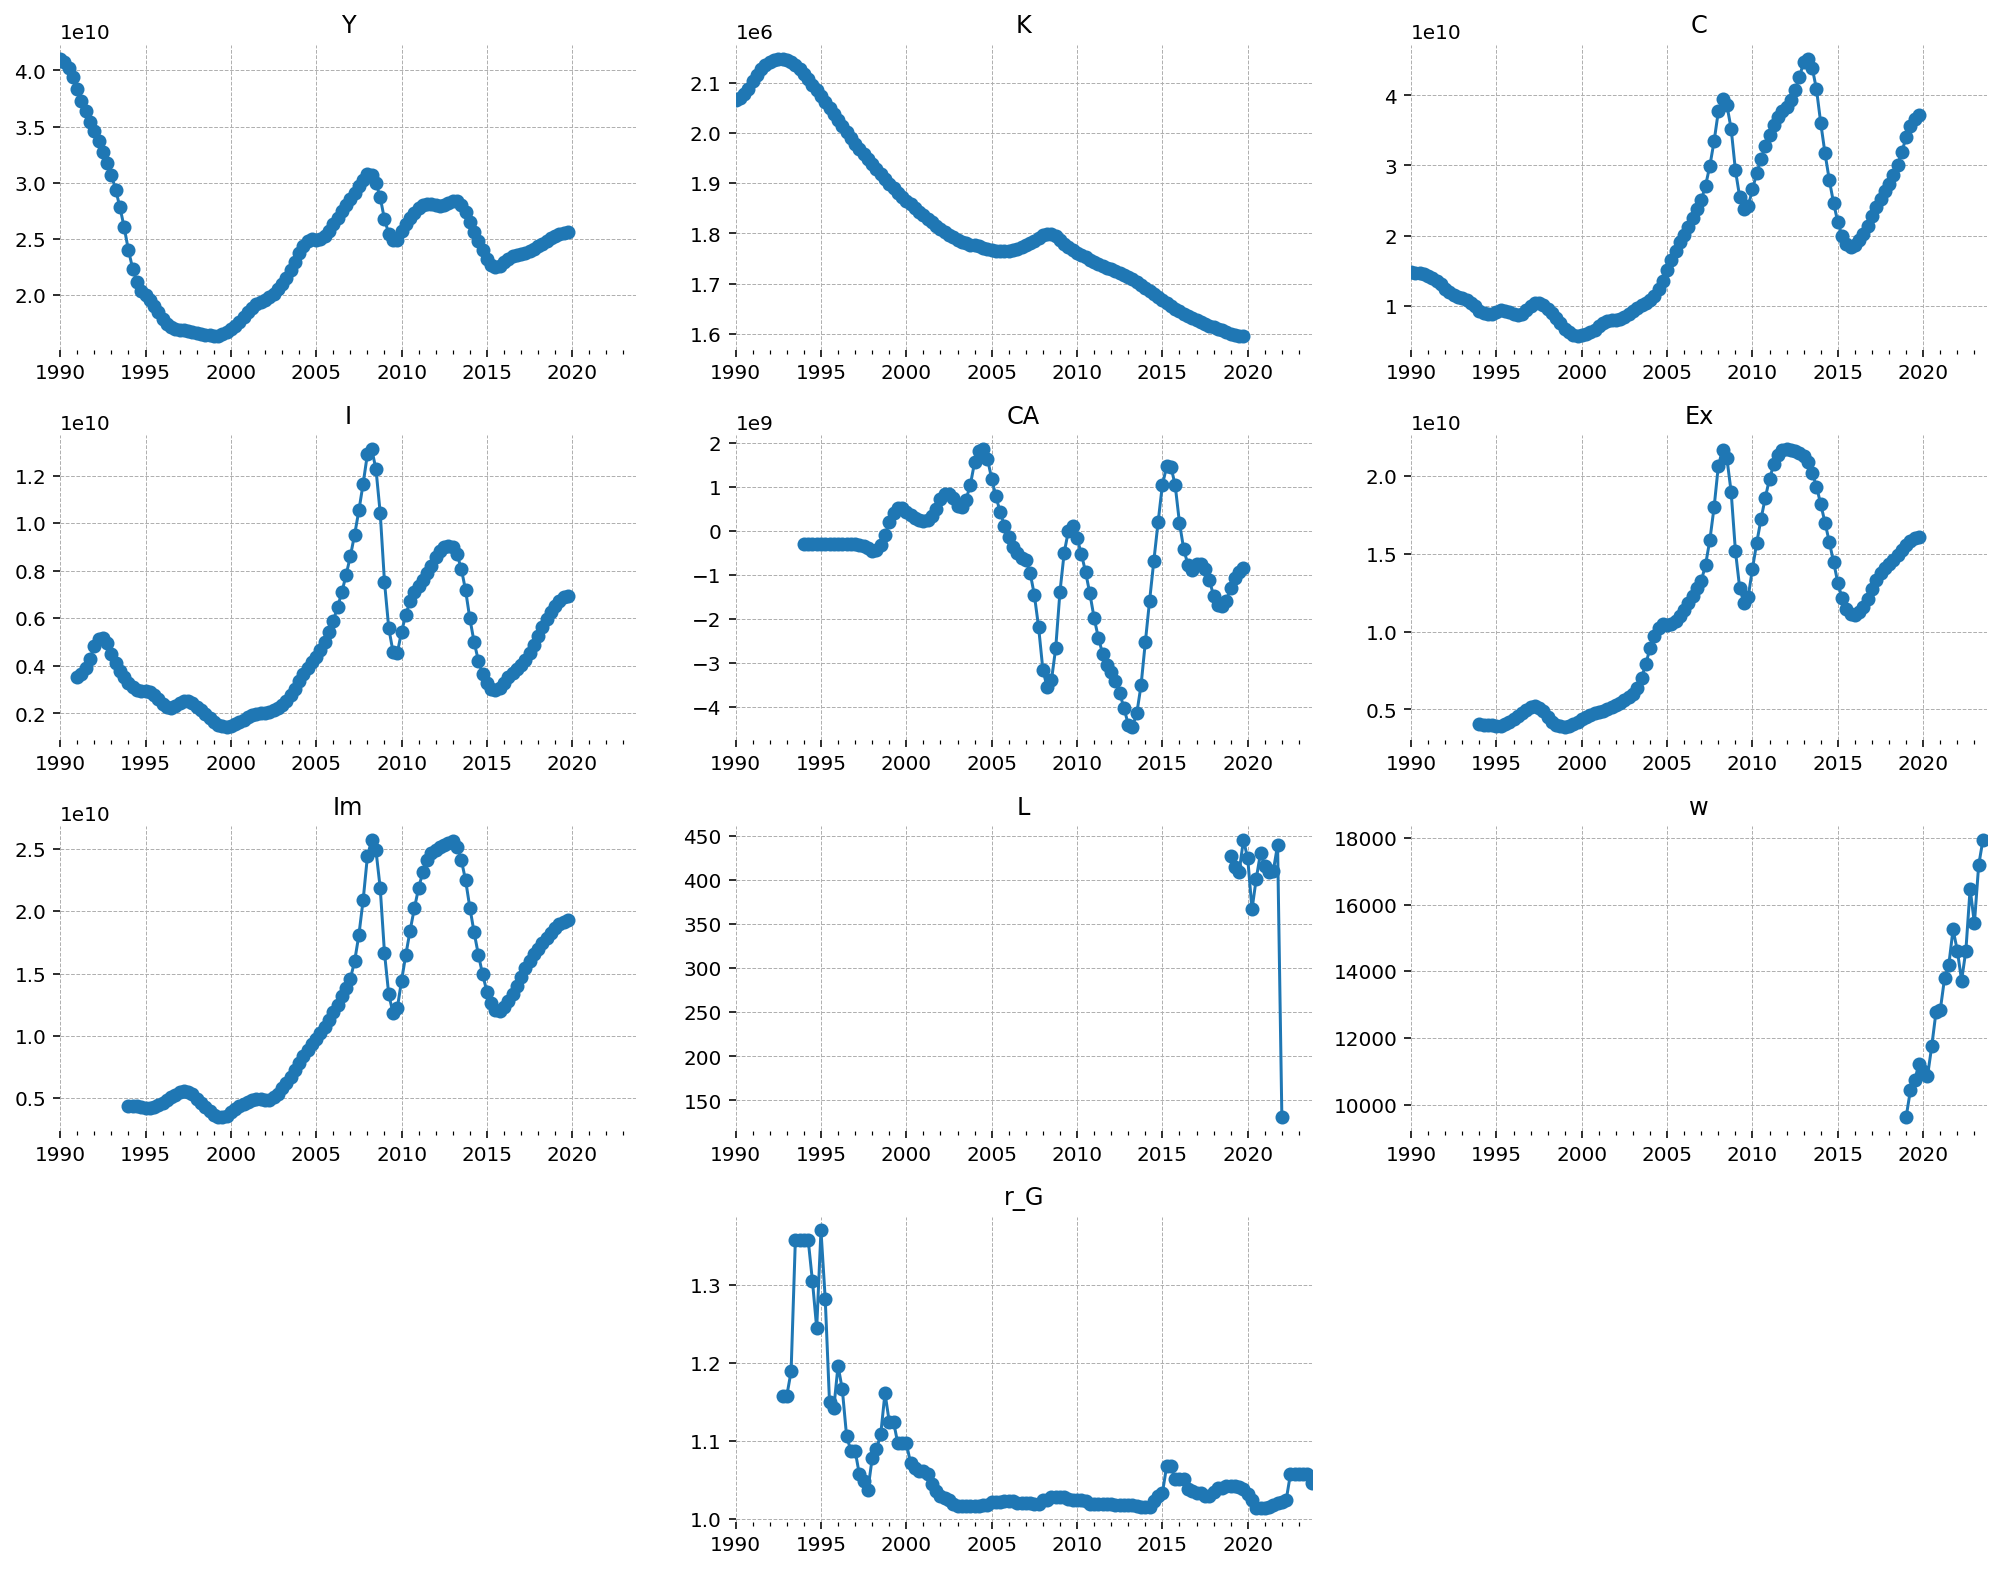

In [26]:
def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(14,11), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()
    
df = data.dropna(how='all')
    
plot_df(data, marker='o')

# Train/Test Split

We split a part of our data into train and test data. We will use the train one to forecast 10 last periods and then compare it to the test data. 

In [27]:
n_test = 10 

data_train = data.iloc[:-n_test, :].copy()
data_test = data.iloc[-n_test:, :].copy()

Now we detrend our data. Firstly, we take logs.

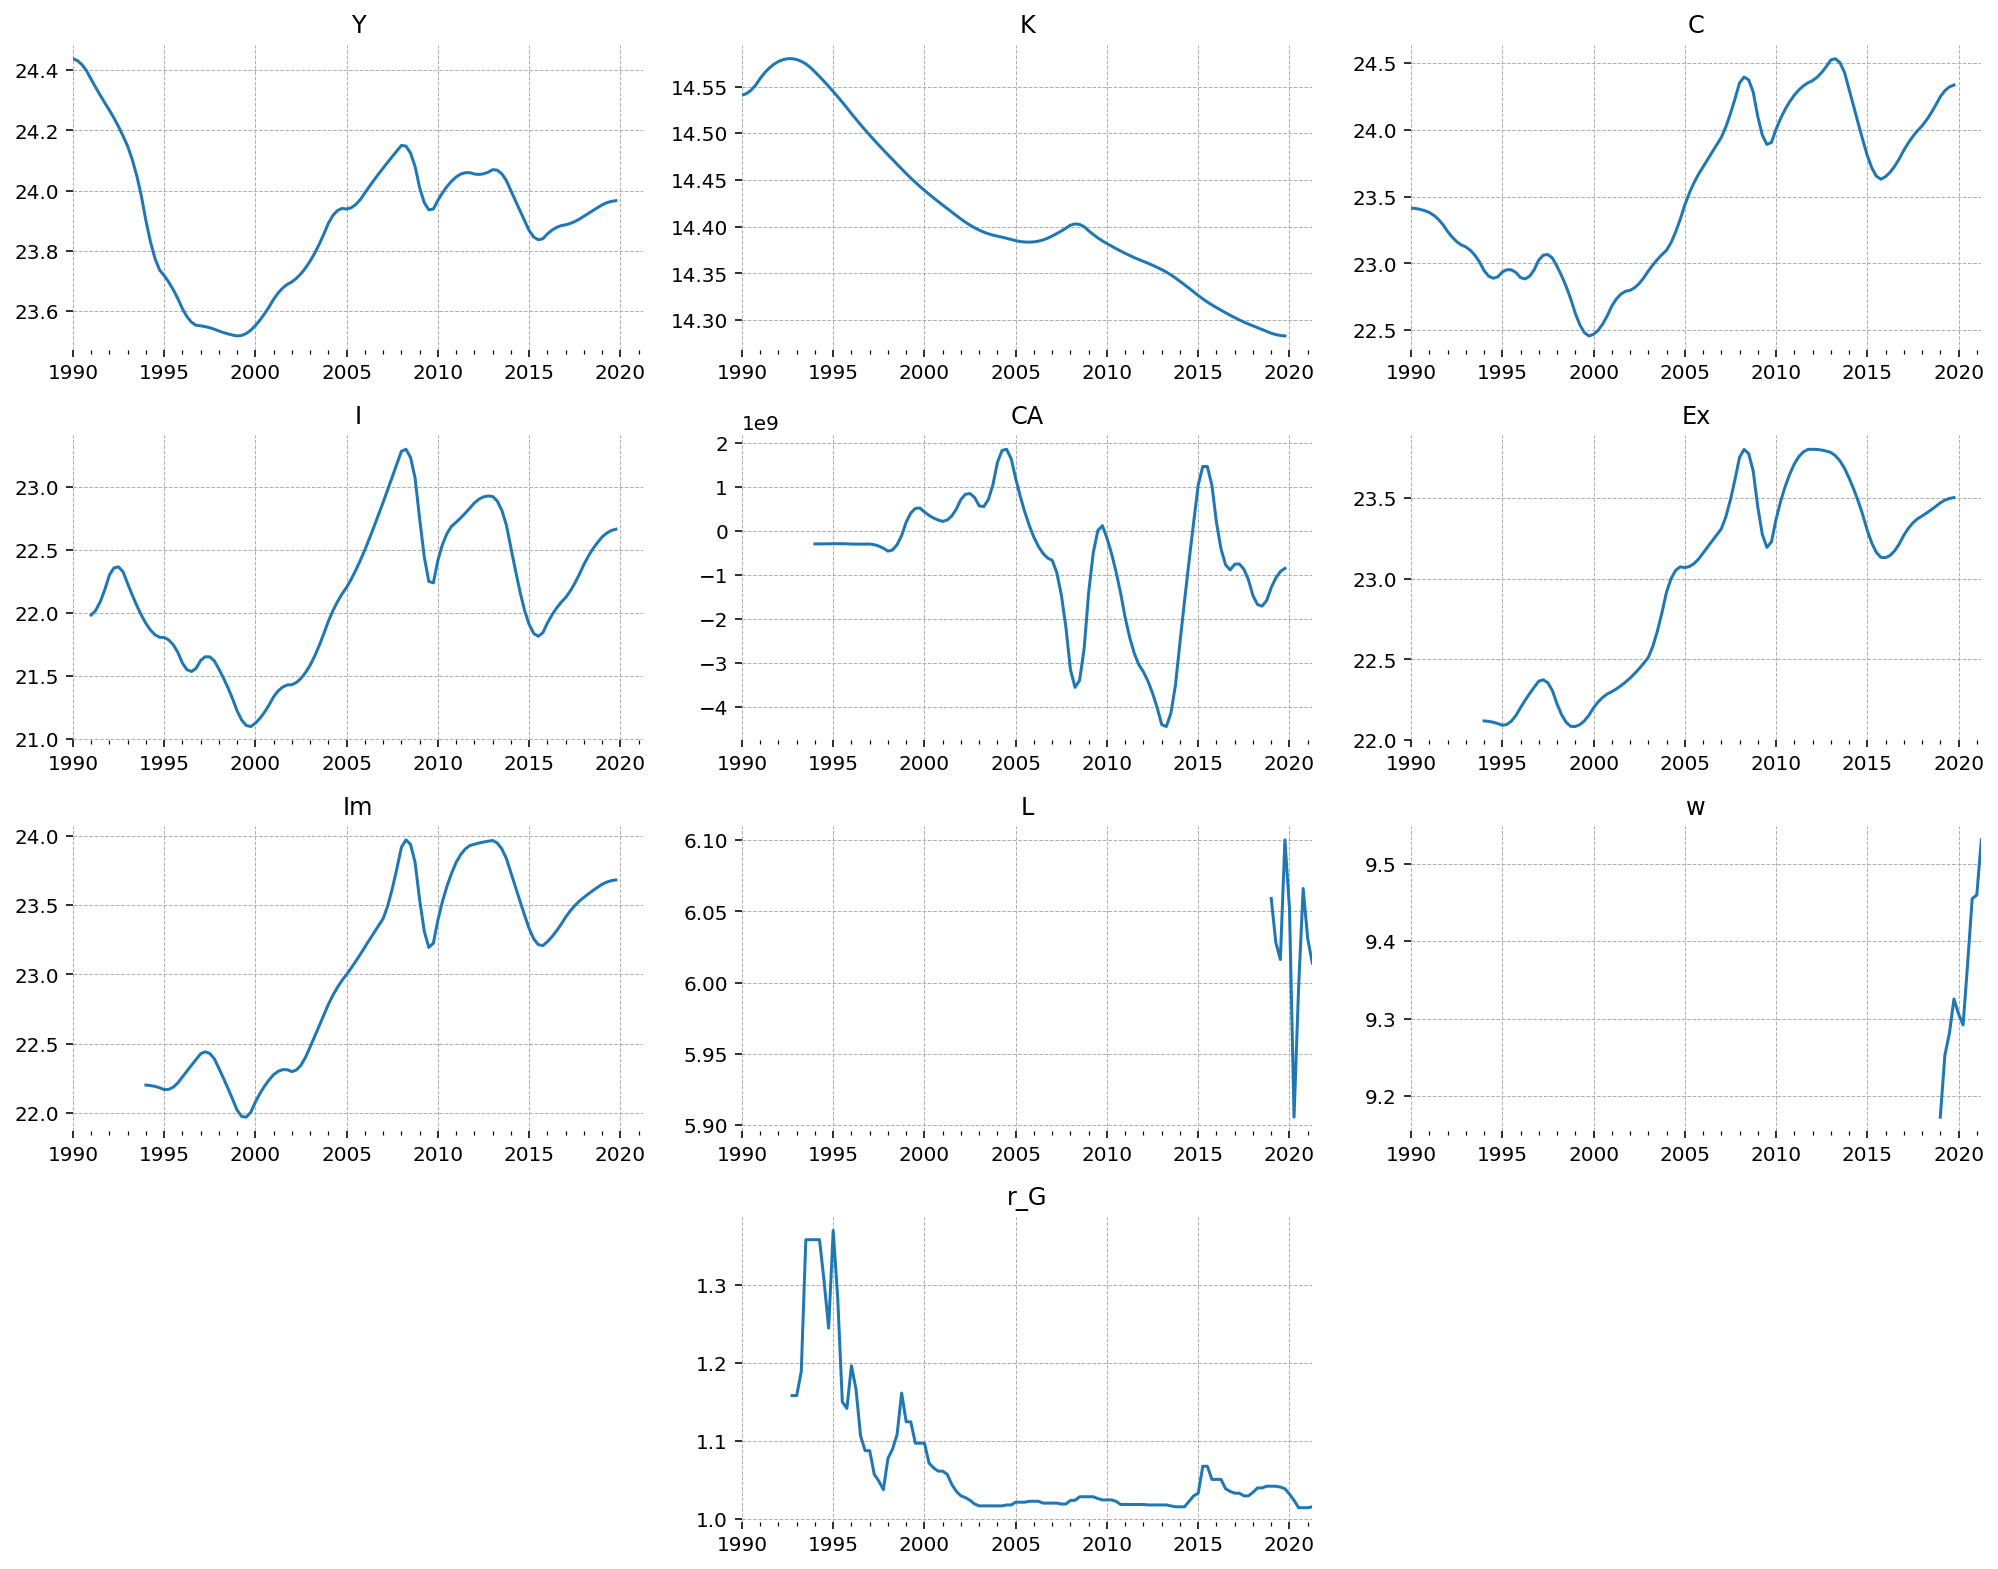

In [28]:
log_data_train = data_train.copy()
log_data_test = data_test.copy()
log_data_train[['Y', 'K','C', 'I', 'Ex', 'Im','w', 'L']] = np.log(log_data_train[['Y', 'K','C', 'I','Ex', 'Im','w','L']])
log_data_test[['Y', 'K','C', 'I', 'Ex', 'Im','w', 'L']] = np.log(log_data_test[['Y', 'K','C', 'I', 'Ex', 'Im','w', 'L']])

plot_df(log_data_train)

In [29]:
ADF_test_summary(log_data_train, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.010         -3.351        0.058         10    -4.044      -3.452     -3.151
	Constant             0.237          3.342        0.001
	Trend                0.000          2.132        0.036
Constant Only               -0.007         -2.615        0.090         10    -3.492      -2.888     -2.581
	Constant             0.168          2.615        0.010
No Constant                 -0.000         -0.069        0.661         10    -2.587      -1.944     -1.615
                                                      K                                                       
Specification               Coeff          Statistic     P-value      La

In [29]:
N = data.shape[0]
constant = np.ones(N)
time = np.arange(N)
X = pd.DataFrame(np.c_[constant, time, time ** 2, time ** 3], 
                 index=data.index, 
                 columns=['constant', 'time', 'time^2', 'time^3'])

X_train = X.iloc[:-n_test, :] 
X_test = X.iloc[-n_test:, :] 

Here we run OLS, save residuals and get rid of the trend.

In [30]:
for variable in ['Y', 'K','C', 'I', 'Ex', 'Im','w','L']:
    mod = sm.OLS(log_data_train[variable], X_train, hasconst=True, missing='drop')
    res = mod.fit()
    detrended_data = res.resid
    log_data_train[variable] = detrended_data
    
    test_pred = res.predict(X_test)
    test_resid = log_data_test[variable] - test_pred
    
    log_data_test[variable] = test_resid
        
r_G_mu_train = log_data_train['r_G'].mean()
log_data_train['r_G'] = log_data_train['r_G'] - r_G_mu_train
log_data_test['r_G'] = log_data_test['r_G'] - r_G_mu_train

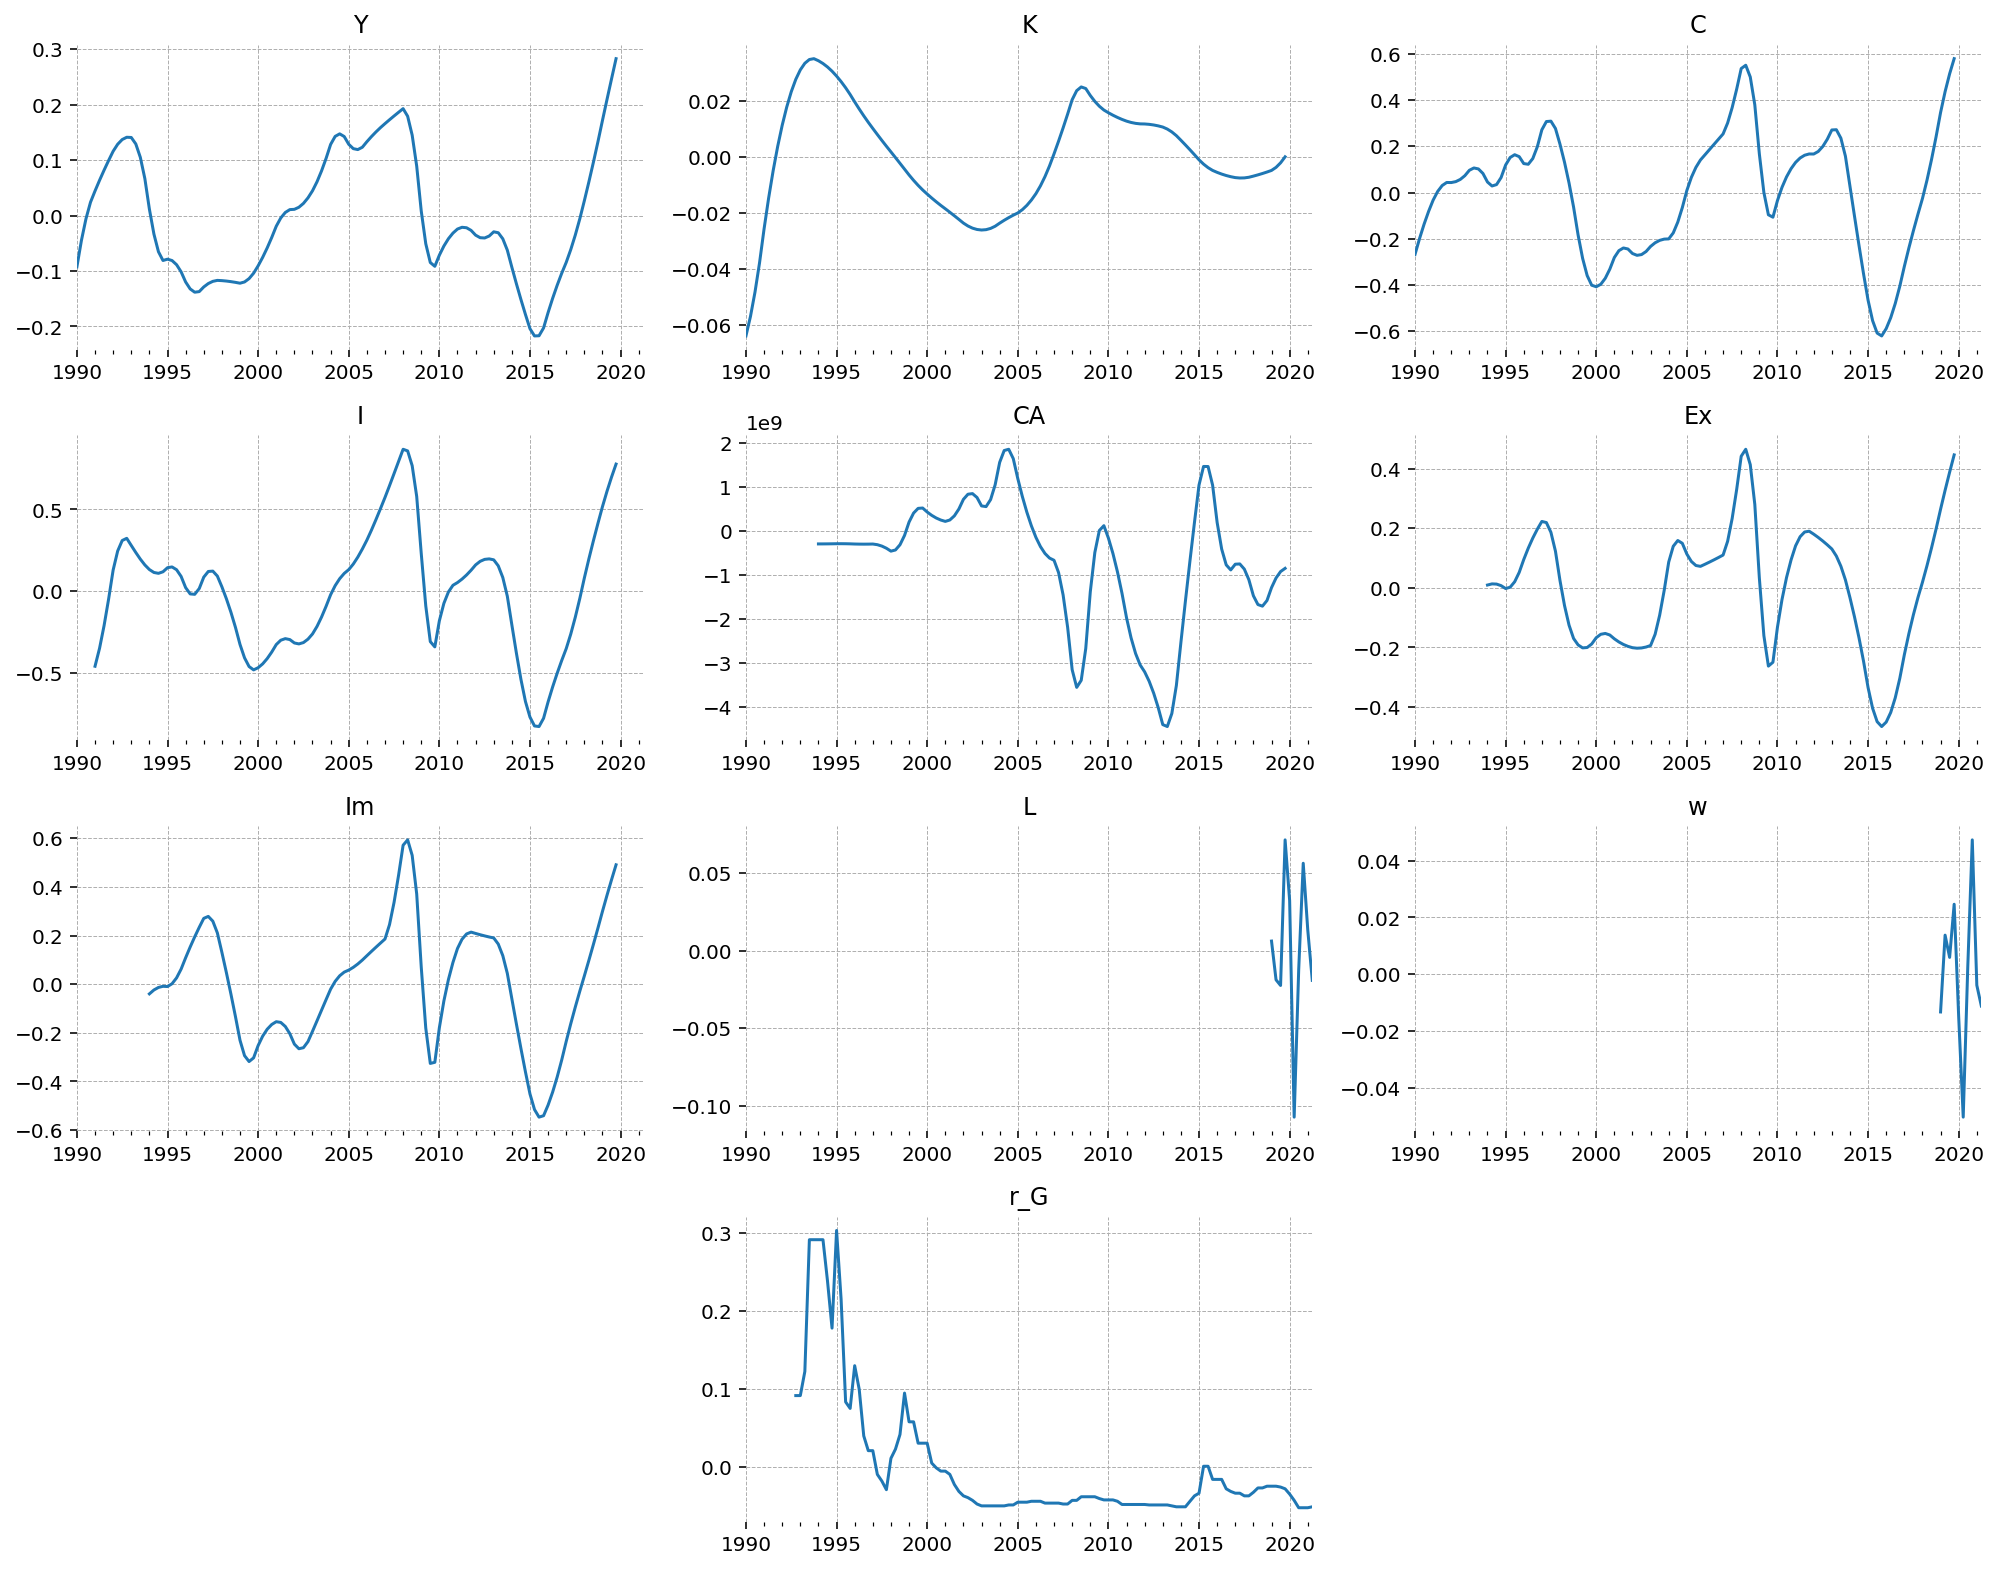

In [31]:
plot_df(log_data_train)

1. The early 1990s were marked by a global economic recession, and Ukraine, as a newly independent country, was not immune to the external economic challenges that affected many nations.The country experienced rapid devaluation of its currency, the hryvnia, which significantly impacted economic stability and eroded the purchasing power of individuals and businesses.
2. The 2008-2009 financial crisis in Ukraine was primarily about the global economic downturn triggered by the collapse of major financial institutions. This crisis had a profound impact on Ukraine due to its interconnectedness with the global economy, resulting in reduced demand for Ukrainian exports, disruptions in international financial markets, and a decline in foreign direct investment, contributing to the severe economic contraction experienced by the country.
3. The significant decline in economic indicators in Ukraine during 2013-2014 was primarily attributed to the combination of the Euromaidan protests and subsequent political revolution, which led to political instability and a change in government. This period was further exacerbated by the annexation of Crimea by Russia and the war in Ukraine, causing disruptions in trade, a sharp depreciation of the national currency, heightened investor uncertainty, and a contraction in economic activity.

In [32]:
ADF_test_summary(log_data_train, missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.010         -1.852        0.679         10    -4.044      -3.452     -3.151
	Constant            -0.001         -1.051        0.296
	Trend                0.000          1.362        0.176
Constant Only               -0.010         -1.815        0.373         10    -3.492      -2.888     -2.581
	Constant             0.000          0.305        0.761
No Constant                 -0.010         -1.865        0.059         10    -2.587      -1.944     -1.615
                                                      K                                                       
Specification               Coeff          Statistic     P-value      La

From the test results we can see that all the data is stationary at "no constant" specification.

In [33]:
data.describe(include='all')

,Y,K,C,I,CA,Ex,Im,L,w,r_G
count,1.200000e+02,1.200000e+02,1.200000e+02,1.160000e+02,1.040000e+02,1.040000e+02,1.040000e+02,13.000000,19.000000,125.000000
mean,2.478721e+10,1.835695e+06,1.957384e+10,4.770912e+09,-6.463942e+08,1.126359e+10,1.233570e+10,394.692308,13391.875120,1.064631
std,5.787076e+09,1.660350e+05,1.153025e+10,2.720797e+09,1.453606e+09,6.001442e+09,7.265900e+09,81.627594,2430.586196,0.080730
min,1.636673e+10,1.596090e+06,5.660241e+09,1.451640e+09,-4.448523e+09,3.899755e+09,3.481624e+09,131.000000,9628.960000,1.014674
25%,2.009401e+10,1.724290e+06,9.293727e+09,2.537203e+09,-1.311419e+09,4.962621e+09,4.902722e+09,409.000000,11112.785000,1.020604
50%,2.483990e+10,1.784818e+06,1.492825e+10,4.083783e+09,-3.032011e+08,1.143924e+10,1.214532e+10,415.000000,13722.648416,1.029884
75%,2.800147e+10,1.960421e+06,2.866726e+10,6.482157e+09,3.098932e+08,1.573307e+10,1.813601e+10,428.000000,14936.790407,1.061576
max,4.105102e+10,2.147721e+06,4.524802e+10,1.311234e+10,1.862693e+09,2.172230e+10,2.572173e+10,446.000000,17937.333680,1.369732


The counts indicate the number of observations available for each variable. For example, the variables "L" and "w" have only 13 and 19 observations respectively, while others have more (we mentioned the reason above).
The mean represents the average value of each variable. For instance, the average GDP (Y) is approximately 2.48e+10, and the average wage rate (w) is around 13391.88.
Standard deviation measures the amount of variation or dispersion in a set of values. A higher standard deviation indicates more spread. Variables like GDP (Y) and Consumption (C) have relatively high standard deviations.
The minimum values show the smallest observed values for each variable. For instance, the minimum GDP (Y) is approximately 1.64e+10.
The 25th percentile (Q1) represents the value below which 25% of the data falls. It provides insight into the lower range of the data distribution.
The median is the middle value of the dataset. It's a measure of central tendency, and here it separates the lower 50% from the upper 50%.
The 75th percentile (Q3) represents the value below which 75% of the data falls. It gives an indication of the upper range of the data distribution.
The maximum values show the largest observed values for each variable. For example, the maximum GDP (Y) is approximately 4.11e+10.

# LITERATURE REVIEW

In constructing the Real Business Cycle (RBC) model for Ukraine, the literature employs diverse approaches to parameter estimation and calibration. The first paper integrates model calibration with parameter estimation, drawing on (Smets, Wouters, 2002) and (Bazhenova, 2009), along with estimates from statistical data provided by the IMF. [1] The second paper focuses on quarterly data from 2002 to 2010, utilizing a simplified approach with three time series (GDP, consumption, and NBU discount rate). Calibration of various variables, such as the capital-to-GDP ratio and β, aligns with prior works, including Bernanke et al. [2].

In the third paper, the model undergoes estimation for the period 2002Q1-2010Q3, and parameters are chosen to align with existing literature, including Annicchiarico and Di Dio (2015), Heutel (2012), and Punzi (2019). Household utility parameters, such as the private discount rate and the Frisch elasticity, are set following Galí (2008) and Christensen and Dib (2008). Additionally, various shock processes, such as Total Factor Productivity (TFP) and monetary policy, are aligned with the values proposed by other studies, ensuring consistency in the parameterization.[3]




Household parameters
1. β represents the household's time preference or discount factor. A value of β = 0.95 implies that households are forward-looking and place significant weight on future utility. A higher β indicates a lower rate of time preference and a stronger desire to smooth consumption over time.
2. δ denotes the depreciation rate of capital. In this case, δ = 0.025 indicates that 2.5% of the capital stock depreciates each period. A lower δ implies slower capital depreciation, reflecting a longer average lifespan of capital goods.
3. σ_c measures the intertemporal elasticity of substitution for consumption. A value of 0.8 suggests that households are relatively risk-averse and prefer a stable consumption profile over time. A higher σ_c indicates a higher degree of substitutability between present and future consumption.
4. σ_l represents the elasticity of labor supply. A value of 1.1 suggests that labor supply is relatively elastic. This implies that households are responsive to changes in wages, and labor supply can easily adjust in response to economic conditions.


FIRM parameters 
1. α denotes the share of capital in the production function. In this case, α = 0.35 indicates that capital contributes 35% to the production process, while the remaining 65% is attributed to labor. A higher α reflects a greater reliance on capital in the production process.


TECHNOLOGY_SHOCKS parameters
1. ρ_A represents the autoregressive parameter for TFP. With ρ_A = 0.99, TFP is highly persistent over time. A high level of persistence suggests that shocks to productivity have a long-lasting impact on the economy.


In [35]:
rbc = ge.gEconModel('/Users/katerynatymoshchuk/Desktop/Macro project python/RBC_w_bonds.gcn')

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



In [36]:
for equation in rbc.system_equations:
    display(equation)

-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

beta*lambda_t+1 - lambda_t/r_G_t

-Div_t + TC_t + Y_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

In [37]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 3.2281156463580534e-30


/Users/katerynatymoshchuk/miniconda3/envs/econ/lib/python3.11/site-packages/gEconpy/classes/model.py:604: UserWarning: The following variables have steady state values close to zero and will not be log linearized: Div
  warn(


Solution found, sum of squared residuals:  1.1742879659800463e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [38]:
rbc.print_steady_state()

A_ss               1.000
C_ss               1.823
Div_ss             0.000
I_ss               0.232
K_ss               9.261
L_ss               0.913
TC_ss             -2.054
Y_ss               2.054
lambda_ss          0.619
r_G_ss             1.053
r_ss               0.078
w_ss               1.462


In [38]:
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

In [41]:
MLEModel = ge.compile_to_statsmodels(rbc)

In [42]:
from gEconpy.classes.transformers import PositiveTransformer, IntervalTransformer
param_start_dict = {'rho_A':0.99}

shock_start_dict = {'epsilon_A':0.1}

noise_start_dict = {'r_G':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.00001, high=0.99, slope=1)}

mle_mod = MLEModel(log_data_train[['Y', 'r_G']].dropna(),
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary',
               fit_MAP=False
               )

/Users/katerynatymoshchuk/miniconda3/envs/econ/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/katerynatymoshchuk/miniconda3/envs/econ/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['constant', 'initial_state_cov']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [43]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mle_res = mle_mod.fit(method="basinhopping", 
                          T=1, 
                          niter=10_000, 
                          niter_success=250, 
                          stepsize=0.1,
                          target_accept_rate=0.5,
                          minimizer={'method':'newton-cg'})


basinhopping step 0: f 68.4848
basinhopping step 1: f 16.0705 trial_f 16.0705 accepted 1  lowest_f 16.0705
found new global minimum on step 1 with function value 16.0705
basinhopping step 2: f 16.0705 trial_f 79.0796 accepted 0  lowest_f 16.0705
basinhopping step 3: f 1.94652 trial_f 1.94652 accepted 1  lowest_f 1.94652
found new global minimum on step 3 with function value 1.94652
basinhopping step 4: f -1.1573 trial_f -1.1573 accepted 1  lowest_f -1.1573
found new global minimum on step 4 with function value -1.1573
basinhopping step 5: f -1.51494 trial_f -1.51494 accepted 1  lowest_f -1.51494
found new global minimum on step 5 with function value -1.51494
basinhopping step 6: f -0.0650762 trial_f -0.0650762 accepted 1  lowest_f -1.51494
basinhopping step 7: f -0.0650762 trial_f 3.2647 accepted 0  lowest_f -1.51494
basinhopping step 8: f -0.0650762 trial_f 3.43002 accepted 0  lowest_f -1.51494
basinhopping step 9: f -1.21048 trial_f -1.21048 accepted 1  lowest_f -1.51494
basinhopping

KeyboardInterrupt: 

1. rho_A: The coefficient for the autoregressive term 'rho_A' is 0.9900. This indicates a high positive correlation with the lagged values of the variable. The z-score is 42.133, suggesting statistical significance.
2. sigma2.epsilon_A: The variance of the error term for variable 'A' is 0.0247 with a z-score of 0.736. The p-value (0.462) suggests that this variance term is not statistically significant.
3. sigma2.r_G: The variance of the error term for variable 'r_G' is 0.1505 with a z-score of 0.670. Similar to the previous term, the p-value (0.503) suggests that this variance term is not statistically significant.

In [42]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:           ['Y', 'r_G']   No. Observations:                  109
Model:                      DSGEModel   Log Likelihood                  71.084
Date:                Wed, 03 Jan 2024   AIC                           -136.167
Time:                        17:57:40   BIC                           -128.093
Sample:                    10-01-1992   HQIC                          -132.893
                         - 10-01-2019                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.9900      0.023     42.133      0.000       0.944       1.036
sigma2.epsilon_A     0.0247      0.034      0.736      0.462      -0.041       0.091
sigma2.r_G           0.1505      0.225      0.670      0.503      -0.290       0.591
===================================================================================
Ljung-Box (L1) (Q):           89.49, 99.47   Jarque-Bera (JB):         35.79, 10.00
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.01
Heteroskedasticity (H):         1.53, 0.55   Skew:                      -1.10, 0.71
Prob(H) (two-sided):            0.21, 0.07   Kurtosis:                   4.74, 3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

The estimated value is very close to the initially calibrated value. This suggests that the autoregressive parameter for variable 'A' is well-matched between the model and the actual data.

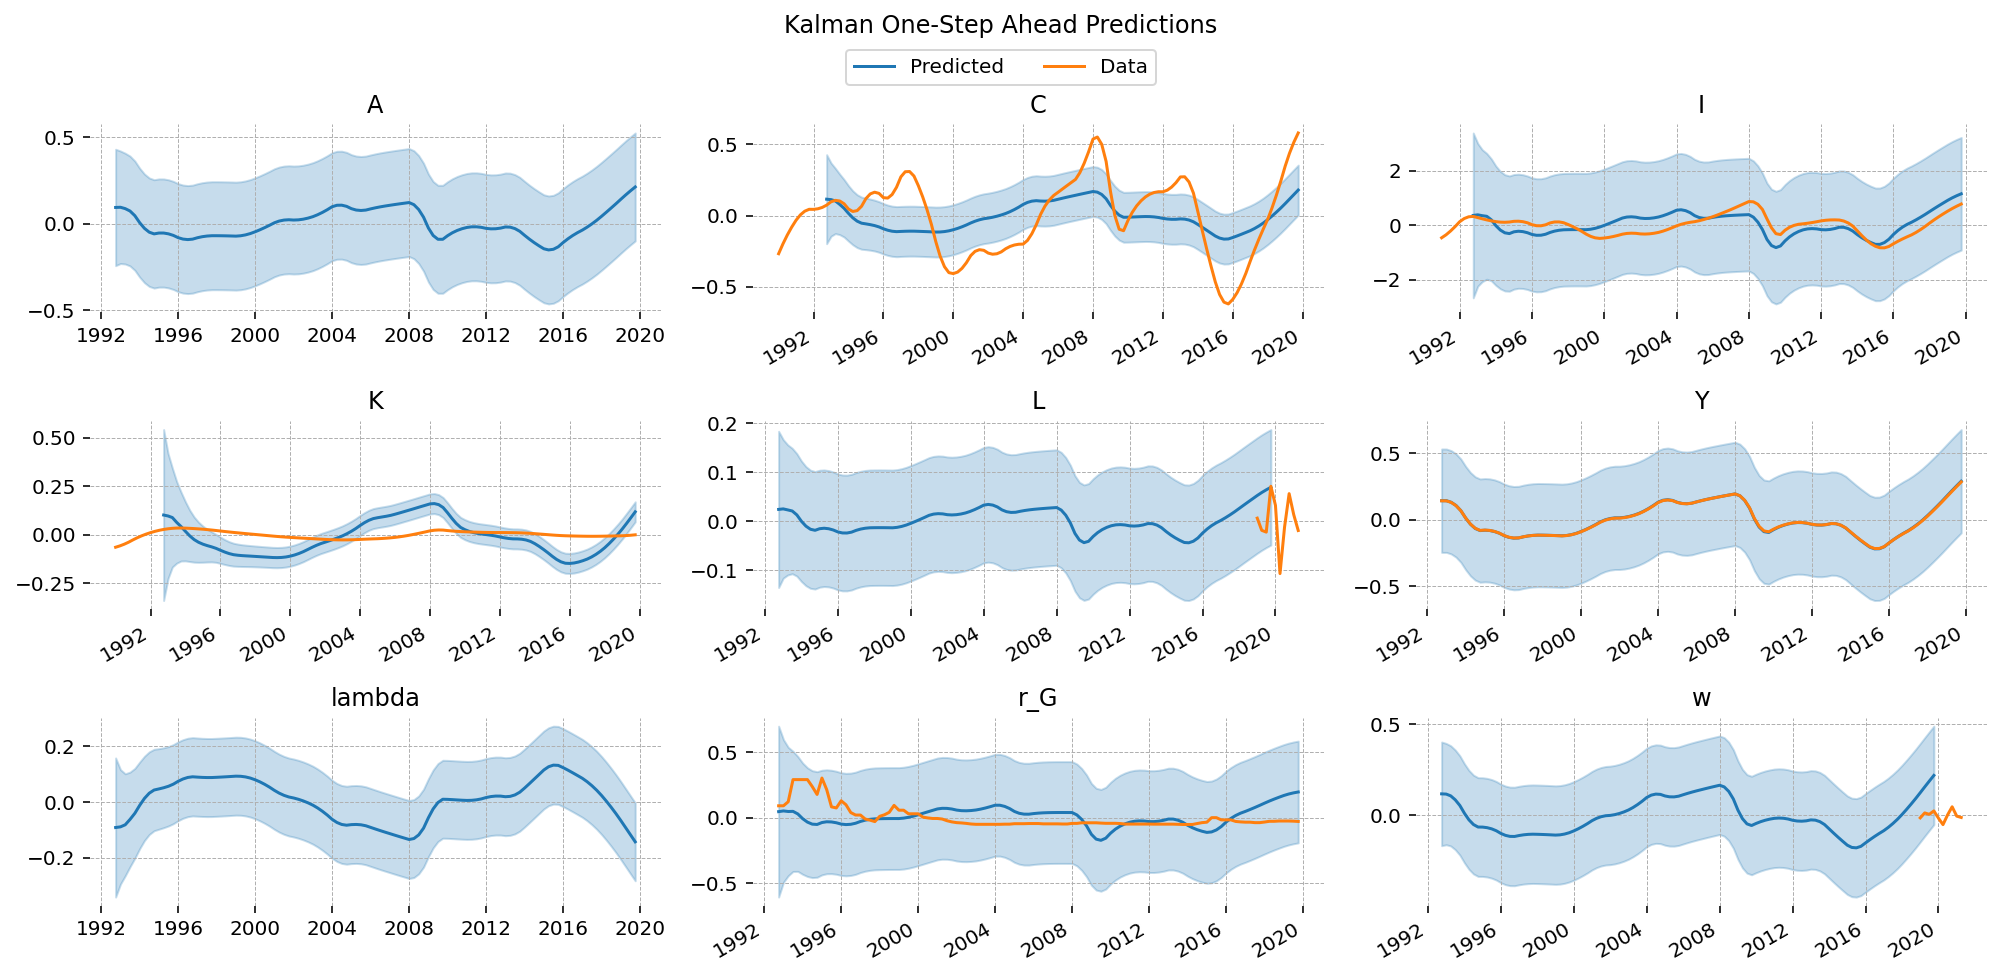

In [43]:
plot_sm_results(mle_res, log_data_train, var_names=vars_to_plot)

We can see that the model works for all the variables but 'C' and 'K'. In our opinion, the issue here is that RBC model has different simplifications and only one TFP shock, while in reality there are many other shocks not explained by the model. 

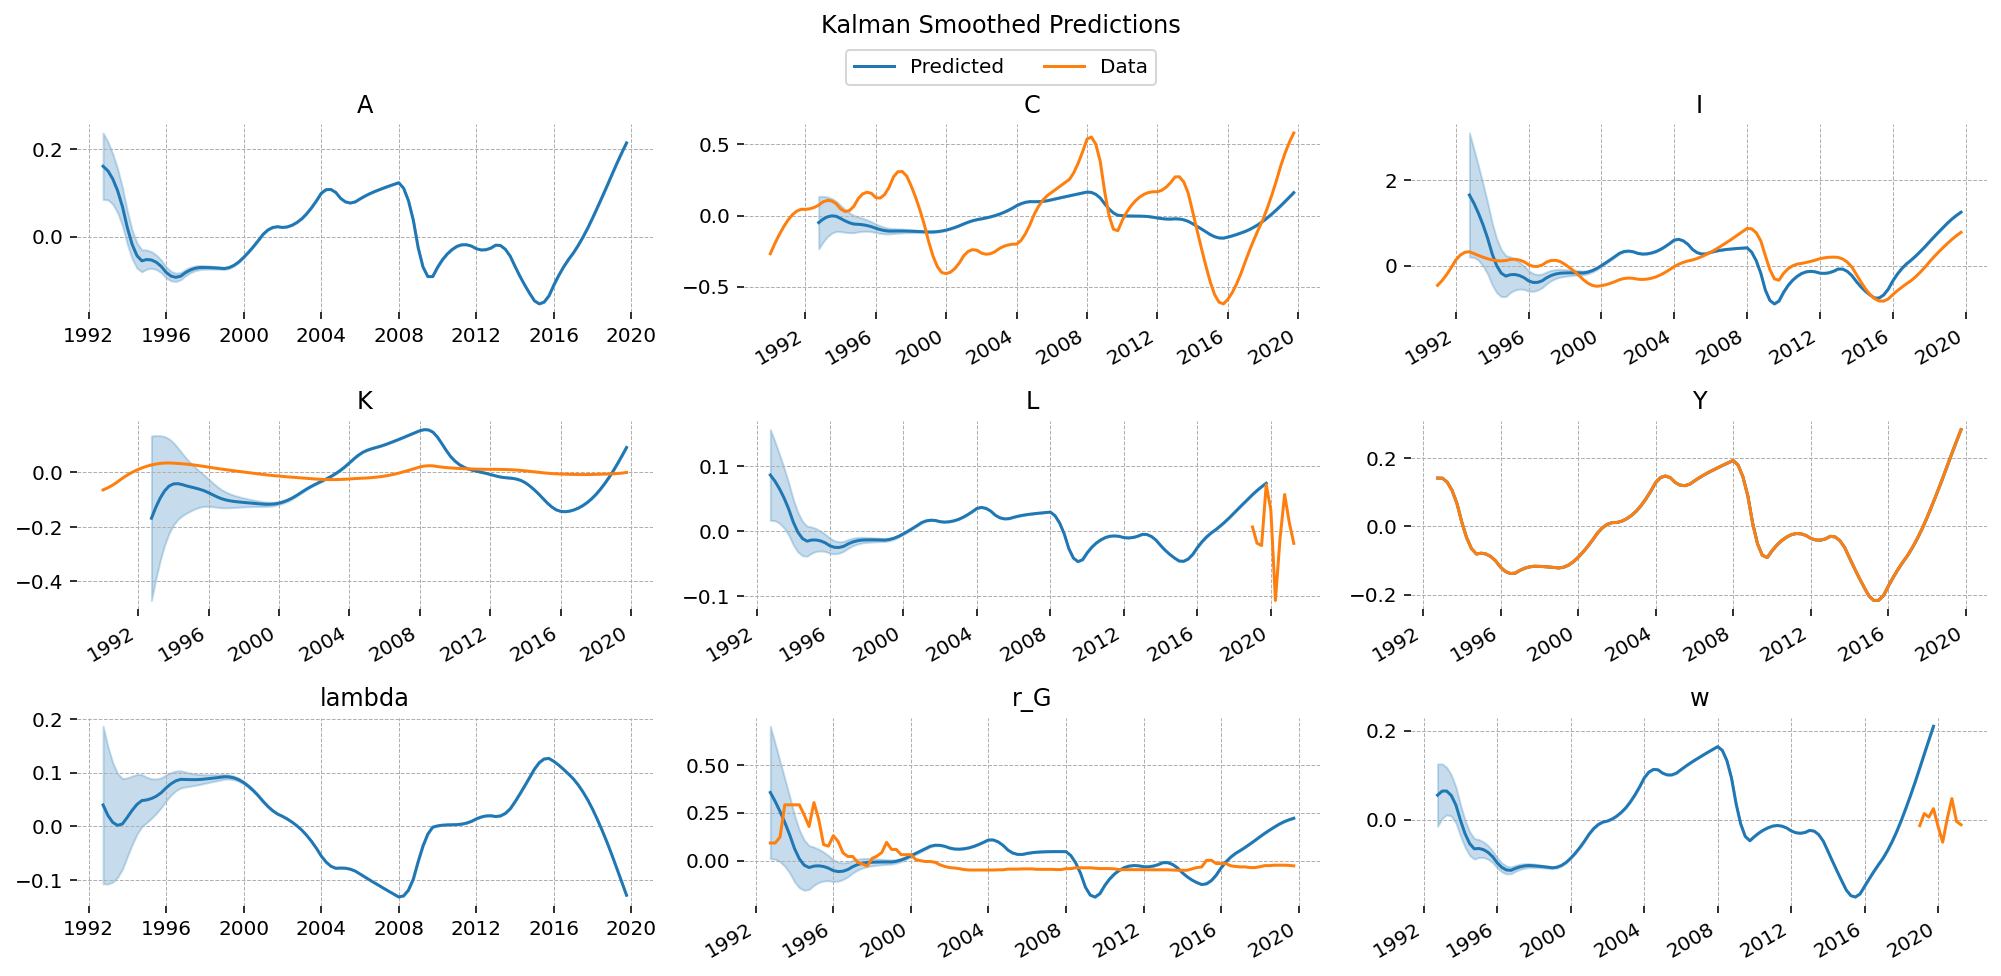

In [44]:
plot_sm_results(mle_res, log_data_train, 'smoothed', var_names=vars_to_plot)

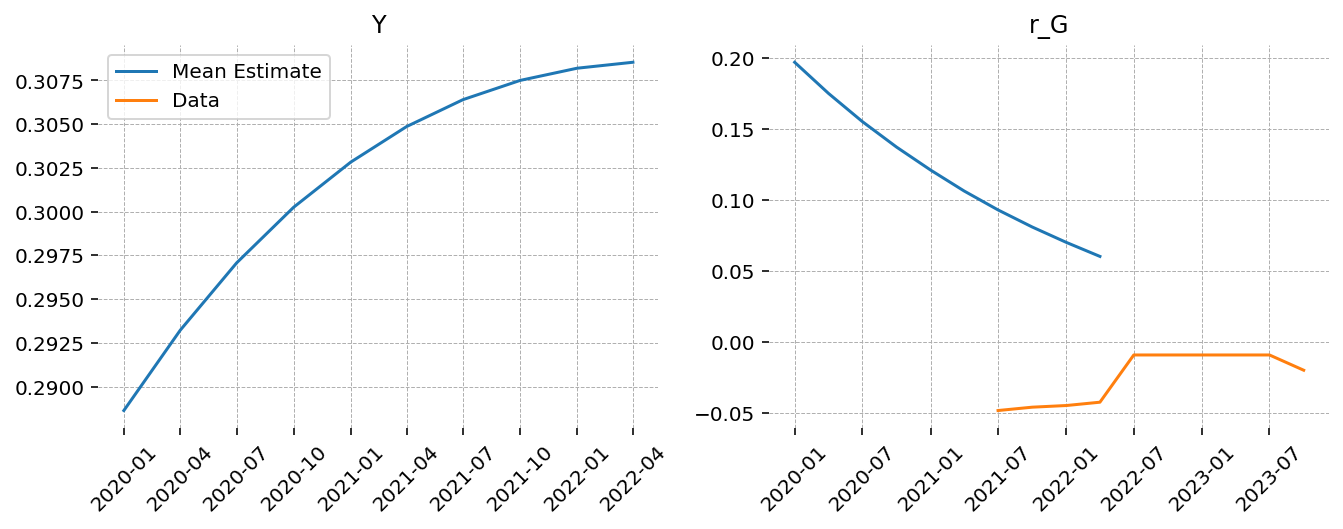

In [47]:
mle_forecast = mle_res.get_forecast(steps=n_test)
mu = mle_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 10))
for var, loc in zip(['Y','r_G',], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(log_data_test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

In [40]:
plot_sm_results(mle_res, log_data_test, var_names=vars_to_plot)

NameError: name 'mle_res' is not defined

In [ ]:
rbc.free_param_dict

In [ ]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

In [ ]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=vars_to_plot)
fig2 = gp.plot_irf(base_irf, vars_to_plot=vars_to_plot)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

Periods of political instability, such as political revolutions or abrupt changes in government, can impact investor confidence and disrupt long-term investment plans. Uncertainty about property rights and the business environment may lead to fluctuations in capital accumulation and affect the TFP series.
Ukraine's economy is sensitive to global commodity prices, particularly for exports like steel and agricultural products. Changes in commodity prices can influence investment in these sectors, affecting the capital stock and, consequently, the TFP time series.
Shifts in trade relations or geopolitical events, especially involving key trading partners like Russia and the European Union, can impact export opportunities and foreign direct investment. Changes in trade dynamics may influence capital accumulation and TFP.
As a country highly dependent on energy imports, variations in global energy prices or disruptions in energy supply can affect production costs, investment decisions, and overall economic efficiency, influencing both capital and TFP.
Policies promoting research and development, technology transfer, and innovation can positively impact TFP. For example, initiatives fostering collaboration between academia and industry or providing incentives for technology adoption could contribute to long-term productivity growth.
Government investments in infrastructure projects, such as transportation, energy, and telecommunications, can have lasting effects on the efficiency of capital and contribute to changes in TFP.